In [1]:
# STEP 1: Setup and imports
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, FloatSlider, IntSlider, Layout, Button, HBox, VBox, Output

# CONFIGURATION - Change these values for each user
USER_ID = 26  # Change this for each user
TCX_FILE = f'data/{USER_ID}-d.tcx'
CHART_IMAGE = f'charts_cropped/user_{USER_ID}.png'
OUTPUT_CSV = f'output/processed/user_{USER_ID}_station_data.csv'

# Set working directory
os.chdir('/Users/anthonymccrovitz/Desktop/Sphery/Sphere Heart Rate Analysis')

# Add scripts directory to path
sys.path.append('scripts')
from parse_tcx import parse_tcx_to_df

# Load data
try:
    df, session_total_sec, sessions_avg_hr, session_max_hr, calories_burned = parse_tcx_to_df(TCX_FILE)
    session_duration_min = session_total_sec / 60
    print(f"Data loaded successfully: {len(df)} data points over {session_duration_min:.2f} minutes")
    print(f"Average HR: {sessions_avg_hr:.1f} bpm, Maximum HR: {session_max_hr} bpm, Calories: {calories_burned}")
except Exception as e:
    print(f"Error loading data: {e}")
    
# Load background image
try:
    img = mpimg.imread(CHART_IMAGE)
    print(f"Background image loaded successfully from {CHART_IMAGE}")
except Exception as e:
    print(f"Error loading background image: {e}")


Data loaded successfully: 195 data points over 48.30 minutes
Average HR: 142.4 bpm, Maximum HR: 177 bpm, Calories: 363
Background image loaded successfully from charts_cropped/user_26.png


In [2]:
# Load user metadata
import pandas as pd
try:
    metadata_df = pd.read_csv('metadata/user_metadata.csv')
    user_meta = metadata_df[metadata_df['user_id'] == USER_ID]
    if not user_meta.empty:
        user_meta = user_meta.iloc[0]
        age = user_meta['age'] if not pd.isna(user_meta['age']) else None
        gender = user_meta['gender'] if not pd.isna(user_meta['gender']) else None
        height_cm = user_meta['height_cm'] if not pd.isna(user_meta['height_cm']) else None
        weight_kg = user_meta['weight_kg'] if not pd.isna(user_meta['weight_kg']) else None
        champ_number = user_meta['champ_number'] if not pd.isna(user_meta['champ_number']) else None
        print(f"Loaded metadata for user {USER_ID}: age={age}, gender={gender}, height={height_cm}cm, weight={weight_kg}kg, champ={champ_number}")
    else:
        print(f"No metadata found for user {USER_ID}")
        age = gender = height_cm = weight_kg = champ_number = None
except Exception as e:
    print(f"Error loading metadata: {e}")
    age = gender = height_cm = weight_kg = champ_number = None


Loaded metadata for user 26: age=None, gender= , height=Nonecm, weight=Nonekg, champ=5


In [3]:
# Global variables to store alignment parameters
# These will be set by the interactive alignment tool and used by the station visualization
global_x_offset = 0
global_x_scale = 1
global_y_min = 0
global_y_max = 200
global_alpha = 0.5


In [4]:
# Create output directories for plots
import os
plots_dir = f'output/plots/user_26'
os.makedirs(plots_dir, exist_ok=True)
print(f"Created plots directory: {plots_dir}")


Created plots directory: output/plots/user_26


In [5]:
# Initialize global alignment parameters
# These will be updated by the interactive alignment tool
current_x_offset = -0.8  # Default starting values
current_x_scale = 1.0
current_y_min = 90
current_y_max = 190
current_alpha = 0.6


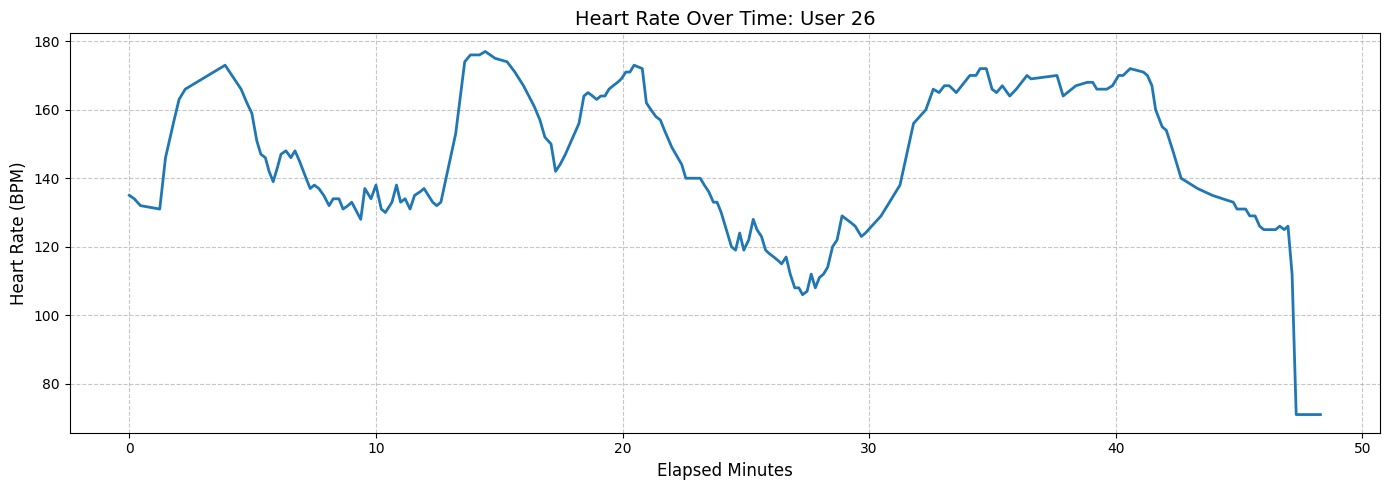

Maximum Heart Rate Details:
                   timestamp  heart_rate                start_time  \
56 2025-05-06 11:08:17+00:00         177 2025-05-06 10:53:51+00:00   

    elapsed_min  
56    14.433333  


In [6]:
# STEP 2: Visualize heart rate data
plt.figure(figsize=(14,5))
plt.plot(df['elapsed_min'], df['heart_rate'], linewidth=2)
plt.xlabel('Elapsed Minutes', fontsize=12)
plt.ylabel('Heart Rate (BPM)', fontsize=12)
plt.title(f'Heart Rate Over Time: User 26', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# Save the plot
plt.savefig(f'{plots_dir}/heart_rate_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

# Show max heart rate point
max_hr_row = df[df['heart_rate'] == df['heart_rate'].max()]
print("Maximum Heart Rate Details:")
print(max_hr_row)


In [7]:
# STEP 3: Align heart rate data with Garmin graph
def update_alignment(x_offset=-0.8, x_scale=1.0, y_min=90, y_max=190, alpha=0.6):
    global current_x_offset, current_x_scale, current_y_min, current_y_max, current_alpha
    current_x_offset = x_offset
    current_x_scale = x_scale
    current_y_min = y_min
    current_y_max = y_max
    current_alpha = alpha
    fig, ax = plt.subplots(figsize=(14,5))
    
    # Calculate extent based on sliders
    x_min = x_offset
    x_max = x_offset + (session_duration_min * x_scale) + 1.2
    
    # Display with current parameters
    ax.imshow(img, aspect='auto', extent=[x_min, x_max, y_min, y_max], 
              alpha=alpha, zorder=0, interpolation='bilinear')
    
    ax.plot(df['elapsed_min'], df['heart_rate'], color='blue', 
            linewidth=2.5, label='Parsed HR Data', zorder=1)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlabel('Elapsed Minutes', fontsize=12)
    ax.set_ylabel('Heart Rate (BPM)', fontsize=12)
    ax.set_title(f'Alignment Parameters: x_offset={x_offset}, x_scale={x_scale}, y_range={y_min}-{y_max}', fontsize=12)
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    # Save the plot
    plt.savefig(f'{plots_dir}/aligned_hr_data.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Current settings: x_offset={x_offset}, x_scale={x_scale}, y_min={y_min}, y_max={y_max}, alpha={alpha}")
    print("Use these values in your final visualization")

# Interactive alignment tool
slider_layout = Layout(width='500px')

interact(update_alignment,
         x_offset=FloatSlider(min=-5, max=5, step=0.1, value=-0.8, description='X Offset:', layout=slider_layout),
         x_scale=FloatSlider(min=0.5, max=1.5, step=0.01, value=1.0, description='X Scale:', layout=slider_layout),
         y_min=IntSlider(min=0, max=100, step=5, value=90, description='Y Min:', layout=slider_layout),
         y_max=IntSlider(min=150, max=250, step=5, value=190, description='Y Max:', layout=slider_layout),
         alpha=FloatSlider(min=0.1, max=1.0, step=0.05, value=0.6, description='Opacity:', layout=slider_layout));


interactive(children=(FloatSlider(value=-0.8, description='X Offset:', layout=Layout(width='500px'), max=5.0, …

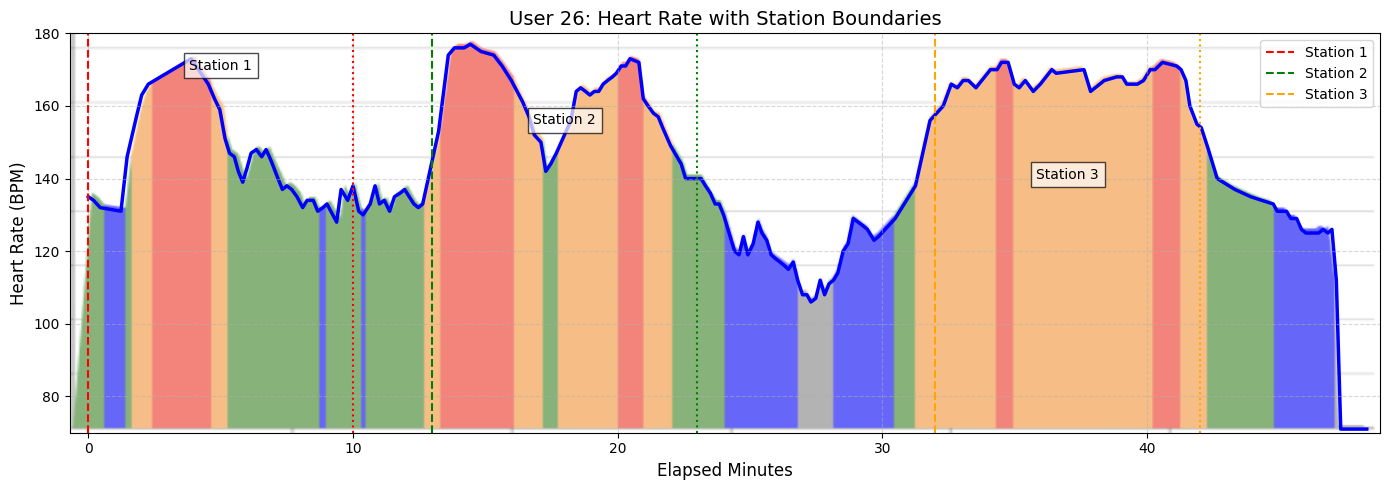

In [10]:
# STEP 4: Define station cutoffs

# Define initial station cutoffs based on visual inspection
# UPDATE THESE FOR EACH USER
cutoffs = [
    (0, 10),    # Station 1
    (13, 23),   # Station 2
    (32, 42)    # Station 3
]

# Function to visualize stations with current cutoffs
def visualize_with_stations(x_offset=None, x_scale=None, y_min=None, y_max=None, alpha=None, cutoffs=None):
    # Use stored alignment parameters if not specified
    global current_x_offset, current_x_scale, current_y_min, current_y_max, current_alpha
    x_offset = current_x_offset if x_offset is None else x_offset
    x_scale = current_x_scale if x_scale is None else x_scale
    y_min = current_y_min if y_min is None else y_min
    y_max = current_y_max if y_max is None else y_max
    alpha = current_alpha if alpha is None else alpha
    # Use provided cutoffs or global cutoffs
    if cutoffs is None:
        cutoffs = globals()['cutoffs']
        
    fig, ax = plt.subplots(figsize=(14,5))
    
    # Calculate extent
    x_min = x_offset
    x_max = x_offset + (session_duration_min * x_scale) + 1.2
    
    # Display background image
    ax.imshow(img, aspect='auto', extent=[x_min, x_max, y_min, y_max], 
              alpha=alpha, zorder=0, interpolation='bilinear')
    
    # Plot HR data
    ax.plot(df['elapsed_min'], df['heart_rate'], color='blue', 
            linewidth=2.5, label='Parsed HR Data', zorder=1)
    
    # Add vertical lines for station boundaries
    colors = ['red', 'green', 'orange']
    for i, (start, end) in enumerate(cutoffs):
        ax.axvline(x=start, color=colors[i % len(colors)], linestyle='--', 
                   label=f'Station {i+1} Start')
        ax.axvline(x=end, color=colors[i % len(colors)], linestyle=':',
                   label=f'Station {i+1} End')
        
        # Add station labels
        y_pos = y_max - 10 - (i * 15)
        ax.text((start + end)/2, y_pos, f'Station {i+1}', 
                horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.7))
    
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlabel('Elapsed Minutes', fontsize=12)
    ax.set_ylabel('Heart Rate (BPM)', fontsize=12)
    ax.set_title(f'User 26: Heart Rate with Station Boundaries', fontsize=14)
    
    # Create a custom legend for station markers
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=colors[i % len(colors)], linestyle='--') 
                    for i in range(len(cutoffs))]
    ax.legend(custom_lines, [f'Station {i+1}' for i in range(len(cutoffs))], 
              loc='upper right')
    
    plt.tight_layout()
    # Save the plot
    plt.savefig(f'{plots_dir}/heart_rate_with_stations.png', dpi=300, bbox_inches='tight')
    plt.show()

# Show initial station boundaries
visualize_with_stations()


In [11]:
# STEP 5: Interactive station boundary adjustment
out = Output()

def station_cutoff_adjuster():
    global cutoffs
    
    # Create sliders for each station boundary
    sliders = []
    for i, (start, end) in enumerate(cutoffs):
        start_slider = FloatSlider(
            value=start,
            min=0,
            max=session_duration_min,
            step=0.1,
            description=f'Station {i+1} Start:',
            style={'description_width': '120px'},
            layout=Layout(width='500px')
        )
        
        end_slider = FloatSlider(
            value=end,
            min=0,
            max=session_duration_min,
            step=0.1,
            description=f'Station {i+1} End:',
            style={'description_width': '120px'},
            layout=Layout(width='500px')
        )
        
        sliders.extend([start_slider, end_slider])
    
    # Update button
    update_btn = Button(
        description='Update Visualization',
        button_style='primary',
        layout=Layout(width='200px')
    )
    
    # Apply button
    apply_btn = Button(
        description='Apply Changes',
        button_style='success',
        layout=Layout(width='200px')
    )
    
    # Create UI layout
    ui = VBox([HBox([update_btn, apply_btn])] + 
              [HBox([sliders[i*2], sliders[i*2+1]]) for i in range(len(cutoffs))])
    
    # Define button actions
    def on_update_clicked(b):
        with out:
            out.clear_output()
            # Update cutoffs from sliders
            new_cutoffs = []
            for i in range(len(cutoffs)):
                start = sliders[i*2].value
                end = sliders[i*2+1].value
                new_cutoffs.append((start, end))
            
            # Visualize with new cutoffs
            visualize_with_stations(cutoffs=new_cutoffs)
            print("Preview of new station boundaries (not yet applied)")
    
    def on_apply_clicked(b):
        with out:
            out.clear_output()
            # Update global cutoffs
            global cutoffs
            new_cutoffs = []
            for i in range(len(cutoffs)):
                start = sliders[i*2].value
                end = sliders[i*2+1].value
                new_cutoffs.append((start, end))
            
            cutoffs = new_cutoffs
            print("Station boundaries updated to:")
            for i, (start, end) in enumerate(cutoffs, 1):
                print(f"Station {i}: {start:.1f} - {end:.1f} minutes")
            
            # Process station data with new cutoffs
            process_station_data()
    
    update_btn.on_click(on_update_clicked)
    apply_btn.on_click(on_apply_clicked)
    
    display(ui)
    display(out)

# Process station data based on current cutoffs
def process_station_data():
    station_rows = []
    
    for i, (start_min, end_min) in enumerate(cutoffs, 1):
        segment = df[(df['elapsed_min'] >= start_min) & (df['elapsed_min'] < end_min)]
        if segment.empty:
            print(f"Warning: No data found for Station {i}")
            continue
            
        station_row = {
            # User and session info
            'user_id': USER_ID,
            'gender': 'NA',
            'circuit_type': 'NA',
            
            # Station info
            
            # User metadata
            'age': age,
            'gender': gender,
            'height_cm': height_cm,
            'weight_kg': weight_kg,
            'champ_number': champ_number,
            'calories_burned': calories_burned,
            
            'station_number': i,
            'station_name': 'NA',
            
            # Session timing and HR data
            'session_start_time': df['timestamp'].iloc[0],
            'session_end_time': df['timestamp'].iloc[-1],
            'session_duration_min': session_duration_min,
            'session_avg_hr': sessions_avg_hr,
            'session_max_hr': session_max_hr,
            
            # Station timing and HR data
            'station_start_time': segment['timestamp'].iloc[0],
            'station_end_time': segment['timestamp'].iloc[-1],
            'station_duration_min': (segment['timestamp'].iloc[-1] - segment['timestamp'].iloc[0]).total_seconds() / 60,
            'station_avg_hr': segment['heart_rate'].mean(),
            'station_max_hr': segment['heart_rate'].max(),
            
            # Per-station ratings
            'motivation': 'NA',  # 1-5 scale
            'enjoyment': 'NA',   # 1-5 scale (previously 'fun')
            'team_experience': 'NA',  # 1-5 scale (only for exergame duos)
            'subjective_physical_exertion': 'NA',  # Borg RPE 1-10 scale
            'subjective_cognitive_exertion': 'NA',  # 1-5 scale
            
            # Final evaluation (same for all stations of a user)
            'overall_experience': 'NA',  # 1-5 scale
            'overall_motivation': 'NA',  # 1-5 scale
            'feedback': 'NA',  # Free text
            
            # Additional data
            'sports_exp': 'NA',
            'gaming_exp': 'NA',
            'data_quality': 'Good',
            'notes': ''
        }
        station_rows.append(station_row)
    
    # Create and display DataFrame
    station_df = pd.DataFrame(station_rows)
    display(station_df)
    
    # Return the DataFrame for further use
    return station_df

# Call the interactive adjuster
station_cutoff_adjuster()


Output()

In [12]:
# STEP 6: Save processed data to CSV
# Function to save station data to CSV
def save_station_data():
    # Get the latest station data
    station_df = process_station_data()
    
    # Save to CSV
    output_path = OUTPUT_CSV
    station_df.to_csv(output_path, index=False)
    print(f"Station data saved to: {output_path}")
    
    return station_df

# Create a button to save data
save_button = Button(
    description='Save Station Data',
    button_style='success',
    layout=Layout(width='200px')
)

save_output = Output()

def on_save_clicked(b):
    with save_output:
        save_output.clear_output()
        save_station_data()

save_button.on_click(on_save_clicked)

display(save_button)
display(save_output)


Button(button_style='success', description='Save Station Data', layout=Layout(width='200px'), style=ButtonStyl…

Output()

In [13]:
# STEP 7: Inspect and validate data
# This will show all columns and rows without truncation

def inspect_data():
    # Get the latest processed data
    inspection_df = process_station_data()
    
    # Set display options to show all rows and columns
    pd.set_option('display.max_rows', None)  # Show all rows
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.width', 1000)  # Wide display
    pd.set_option('display.max_colwidth', None)  # Don't truncate column contents
    
    # Print the full DataFrame
    print("\n===== FULL DATAFRAME INSPECTION =====\n")
    print(inspection_df)
    print("\n===== END OF DATAFRAME =====\n")
    
    # Show DataFrame info (types and non-null values)
    print("\n===== DATAFRAME INFO =====\n")
    inspection_df.info()
    
    # Show DataFrame statistics
    print("\n===== DATAFRAME STATISTICS =====\n")
    print(inspection_df.describe())
    
    # Reset display options to default
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')
    
    # CSV preview
    import io
    
    # Create a string buffer and write the CSV to it
    buffer = io.StringIO()
    inspection_df.to_csv(buffer, index=False)
    
    # Reset the buffer position to the beginning
    buffer.seek(0)
    
    # Read and print the CSV content
    csv_content = buffer.getvalue()
    print("\n===== CSV PREVIEW =====\n")
    print(csv_content[:2000] + "..." if len(csv_content) > 2000 else csv_content)
    print("\n===== END OF CSV PREVIEW =====\n")
    
    # Validation
    print("\n===== CSV VALIDATION =====\n")
    print(f"Number of rows: {len(inspection_df)}")
    print(f"Number of columns: {len(inspection_df.columns)}")
    
    # Check for missing values
    missing_values = inspection_df.isnull().sum().sum()
    print(f"Total missing values: {missing_values}")
    if missing_values > 0:
        print("Columns with missing values:")
        print(inspection_df.isnull().sum()[inspection_df.isnull().sum() > 0])
    
    # Check for potential delimiter issues in string columns
    for col in inspection_df.select_dtypes(include=['object']).columns:
        if inspection_df[col].str.contains(',').any():
            print(f"Warning: Column '{col}' contains commas which might cause CSV parsing issues")

# Create a button to inspect data
inspect_button = Button(
    description='Inspect Data',
    button_style='info',
    layout=Layout(width='200px')
)

inspect_output = Output()

def on_inspect_clicked(b):
    with inspect_output:
        inspect_output.clear_output()
        inspect_data()

inspect_button.on_click(on_inspect_clicked)

display(inspect_button)
display(inspect_output)


Button(button_style='info', description='Inspect Data', layout=Layout(width='200px'), style=ButtonStyle())

Output()

In [14]:
# STEP 8: Analyze high heart rate periods to help with station identification
def analyze_hr_patterns():
    # Find high heart rate periods that might indicate stations
    print("\n===== POTENTIAL STATION BOUNDARIES =====\n")
    # Calculate rolling average to smooth the data
    df['smooth_hr'] = df['heart_rate'].rolling(window=5, center=True).mean()
    
    # Find significant changes in heart rate (potential station boundaries)
    df['hr_change'] = df['smooth_hr'].diff().abs()
    significant_changes = df[df['hr_change'] > 10].sort_values('hr_change', ascending=False).head(10)
    print("Potential station boundaries (large heart rate changes):")
    print(significant_changes[['timestamp', 'elapsed_min', 'heart_rate', 'hr_change']])
    
    # Find periods of sustained high heart rate
    high_hr_threshold = sessions_avg_hr + 10  # 10 BPM above average
    high_hr_periods = df[df['heart_rate'] > high_hr_threshold]
    print("\nHigh heart rate periods (potential stations):")
    print(f"Threshold: {high_hr_threshold} BPM")
    
    # Group consecutive high HR points to identify distinct periods
    if not high_hr_periods.empty:
        # Find gaps in the high HR periods
        high_hr_periods['gap'] = high_hr_periods['elapsed_min'].diff() > 1.0
        high_hr_periods['period'] = high_hr_periods['gap'].cumsum()
        
        # Summarize each period
        period_summary = high_hr_periods.groupby('period').agg(
            start_time=('elapsed_min', 'min'),
            end_time=('elapsed_min', 'max'),
            duration=('elapsed_min', lambda x: x.max() - x.min()),
            avg_hr=('heart_rate', 'mean'),
            max_hr=('heart_rate', 'max')
        ).reset_index()
        
        # Filter to show only significant periods (longer than 1 minute)
        significant_periods = period_summary[period_summary['duration'] > 1.0]
        print("\nSignificant high heart rate periods (potential stations):")
        print(significant_periods[['start_time', 'end_time', 'duration', 'avg_hr', 'max_hr']])
        
        # Visualize these periods
        plt.figure(figsize=(14,5))
        plt.plot(df['elapsed_min'], df['heart_rate'], linewidth=2)
        
        # Highlight high HR periods
        for _, period in significant_periods.iterrows():
            plt.axvspan(period['start_time'], period['end_time'], 
                       alpha=0.2, color='red', 
                       label=f"HR Period: {period['start_time']:.1f}-{period['end_time']:.1f} min")
        
        plt.xlabel('Elapsed Minutes', fontsize=12)
        plt.ylabel('Heart Rate (BPM)', fontsize=12)
        plt.title(f'User 26: High Heart Rate Periods', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        # Save the plot
        plt.savefig(f'{plots_dir}/high_hr_periods.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Suggest station cutoffs based on high HR periods
        print("\nSuggested station cutoffs based on high HR periods:")
        for i, period in enumerate(significant_periods.iterrows(), 1):
            if i <= 3:  # Assuming 3 stations maximum
                _, p = period
                # Add some padding to the periods
                start = max(0, p['start_time'] - 0.5)
                end = min(session_duration_min, p['end_time'] + 0.5)
                print(f"Station {i}: ({start:.1f}, {end:.1f})")

# Create a button to analyze HR patterns
analyze_button = Button(
    description='Analyze HR Patterns',
    button_style='warning',
    layout=Layout(width='200px')
)

analyze_output = Output()

def on_analyze_clicked(b):
    with analyze_output:
        analyze_output.clear_output()
        analyze_hr_patterns()

analyze_button.on_click(on_analyze_clicked)

display(analyze_button)
display(analyze_output)


Button(button_style='warning', description='Analyze HR Patterns', layout=Layout(width='200px'), style=ButtonSt…

Output()